In [37]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from itertools import combinations
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from pykalman import KalmanFilter
from math import sqrt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [32]:
# ─── PARAMETERS ─────────────────────────────────────────────────────────────
START_DATE = "2018-01-01"
END_DATE   = "2025-01-01"
OUT_CSV    = "vn_top500_closes_2018_2025.csv"
EXCHANGE   = "HOSE,HNX,UPCOM"
SOURCES     = ['VCI', 'SSI']

TRAIN_FRAC = 0.7       # 70% train / 30% test
MIN_COMMON = 100       # min days overlap
P_THRESH   = 0.05      # cointegration p-value threshold
ENTRY_Z    = 1.25      # entry z-score
EXIT_Z     = 0.5       # exit z-score
MIN_HL     = 5
MAX_HL     = 252
COMMISSION = 0.002    # 0.2% round-trip split per side
SLIPPAGE   = 0.0015 
MIN_COVERAGE_PCT = 0.90   # require ≥90% of the “best” non-NaN days
WF_TRAIN_WINDOW = 12    # Training window in months for walk-forward
WF_TEST_WINDOW = 3      # Test window in months for walk-forward


In [31]:
# ─── SECTION 1: DATA RETRIEVAL & CLEANING ────────────────────────────────────

# 1) Load price matrix
px = pd.read_csv(
    "/Users/lephuongnghi/Desktop/quant/personal/pairs_trading/notebooks/data_vn/vn_top500_closes_2018_2025_90pct.csv",
    index_col=0,
    parse_dates=True
)

# 2) Coerce to float & zero → NaN, then drop any symbols with missing data
px = px.astype(float).where(px > 0).dropna(axis='columns', how='any')

# Sanity check
print(f"[Data] Loaded & cleaned price matrix → {px.shape[0]} dates × {px.shape[1]} symbols")
print(px.head())

[Data] Loaded & cleaned price matrix → 1750 dates × 234 symbols
              VCB    VIC    BID     ACV    CTG    FPT    HPG   MBB   VPB  \
date                                                                       
2018-01-02  23.41  57.44  14.90  115.03  16.65  18.33  10.85  7.63  8.73   
2018-01-03  23.37  59.13  14.79  110.68  16.55  18.33  10.82  7.55  8.74   
2018-01-04  23.58  59.50  15.20  115.03  17.15  18.70  10.96  7.57  9.06   
2018-01-05  22.98  58.77  15.12  115.03  16.75  18.39  10.91  7.51  8.96   
2018-01-08  23.58  58.99  15.37  112.71  17.15  18.67  11.25  7.89  9.37   

              GAS  ...   BTP    SKG   G36   S99   DLG   CMX   KHP   CNT   HUG  \
date               ...                                                          
2018-01-02  57.64  ...  5.59  17.06  5.34  3.93  3.56  2.64  4.88  1.26  7.13   
2018-01-03  58.91  ...  5.59  16.80  5.34  3.93  3.49  2.63  4.88  1.26  7.13   
2018-01-04  61.69  ...  5.54  16.70  5.34  3.93  3.62  2.68  4.88  1.26  6.13  

In [49]:
# ─── CONSTANTS ────────────────────────────────────────────────────────────────
MIN_COMMON = 100
MIN_HL     = 5
MAX_HL     = 252

class RobustBacktester:
    def __init__(self, px_data, config):
        self.px               = px_data.copy()
        self.config           = config
        self.train_data       = None
        self.validation_data  = None
        self.test_data        = None
        self.wf_results       = []
        self.wf_performance   = pd.DataFrame()

    def split_data(self):
        dates = self.px.index.sort_values()
        n     = len(dates)
        i1    = int(n * 0.55)
        i2    = int(n * 0.75)
        self.train_data      = self.px.loc[:dates[i1-1]]
        self.validation_data = self.px.loc[dates[i1]:dates[i2-1]]
        self.test_data       = self.px.loc[dates[i2]:]
        print(f"Train  : {self.train_data.index.min().date()} → {self.train_data.index.max().date()}")
        print(f"Val    : {self.validation_data.index.min().date()} → {self.validation_data.index.max().date()}")
        print(f"Test   : {self.test_data.index.min().date()} → {self.test_data.index.max().date()}")

    def find_cointegrated_pairs(self, data, min_obs=MIN_COMMON):
        log_px = np.log(data.replace(0, np.nan))
        syms   = log_px.columns
        pairs  = []
        for i in range(len(syms)):
            for j in range(i+1, len(syms)):
                x = log_px[syms[i]].dropna()
                y = log_px[syms[j]].dropna()
                idx = x.index.intersection(y.index)
                if len(idx) < min_obs:
                    continue
                x0, y0 = x.loc[idx], y.loc[idx]
                if x0.std() == 0 or y0.std() == 0:
                    continue
                try:
                    _, p, _ = coint(x0, y0)
                except:
                    continue
                if p < self.config['p_thresh']:
                    pairs.append((syms[i], syms[j], p))
        return pairs

    def kalman_filter_smooth(self, series):
        kf = KalmanFilter(
            transition_matrices=[1],
            observation_matrices=[1],
            initial_state_mean=series.iloc[0],
            initial_state_covariance=1.0,
            observation_covariance=max(0.1, series.pct_change().std()),
            transition_covariance=max(0.01, series.pct_change().std()*0.1)
        )
        m, _ = kf.filter(series.values)
        return pd.Series(m.flatten(), index=series.index)

    def kalman_regression(self, x, y, delta=1e-3):
        trans_cov = delta/(1-delta) * np.eye(2)
        obs_mat   = np.expand_dims(np.vstack([x, np.ones(len(x))]).T, axis=1)
        kf = KalmanFilter(
            n_dim_obs=1, n_dim_state=2,
            initial_state_mean=[0,0],
            initial_state_covariance=np.eye(2),
            transition_matrices=np.eye(2),
            observation_matrices=obs_mat,
            observation_covariance=max(0.1, y.pct_change().std()),
            transition_covariance=trans_cov
        )
        means, _ = kf.filter(y.values)
        return means[:,0]

    def test_pair_strategy(self, sym1, sym2, params, data):
        dfp = data[[sym1, sym2]].dropna()
        x, y = dfp[sym1], dfp[sym2]
        mx, my = self.kalman_filter_smooth(x), self.kalman_filter_smooth(y)
        hr      = -self.kalman_regression(mx, my)
        spread  = y + hr * x

        # half-life regression
        lag   = spread.shift(1)
        regdf = pd.concat([(spread - lag).rename('delta'),
                           lag.rename('lag')], axis=1).dropna()
        if regdf['lag'].std() == 0:
            return None
        try:
            beta = sm.OLS(regdf['delta'], sm.add_constant(regdf['lag'])).fit().params['lag']
        except:
            return None
        hl = max(MIN_HL, min(int(round(-np.log(2)/beta)), MAX_HL))

        # rolling stats
        m = spread.rolling(hl).mean()
        s = spread.rolling(hl).std().replace(0,1e-8)
        z = (spread - m) / s

        # dynamic thresholds on z-score
        e_z, x_z = params['entry_z'], params['exit_z']
        long_sig  = (z < -e_z).astype(int)
        short_sig = (z >  e_z).astype(int)
        pos       = (long_sig - short_sig).shift(1).ffill().fillna(0)

        notional  = abs(hr)*x + y
        ret       = spread.diff() / notional.shift(1)
        strat     = ret * pos
        trades    = pos.diff().abs()
        cost_rate = self.config['commission'] + self.config['slippage']
        net_ret   = strat - trades * cost_rate
        eq        = (1 + net_ret.fillna(0)).cumprod()

        ann_ret = net_ret.mean() * 252
        ann_vol = net_ret.std()  * sqrt(252)
        sharpe  = ann_ret / ann_vol if ann_vol>0 else np.nan
        max_dd  = ((eq.cummax() - eq) / eq.cummax()).max()
        total   = eq.iloc[-1] - 1
        win_rt  = (net_ret > 0).mean()
        n_trades= int(trades.sum())

        return {
            'pair':         f"{sym1}/{sym2}",
            'equity_curve': eq,
            'sharpe':       sharpe,
            'total_return': total,
            'max_drawdown': max_dd,
            'win_rate':     win_rt,
            'num_trades':   n_trades,
            'half_life':    hl
        }

    def optimize_thresholds(self, sym1, sym2, opt_data):
        best_sharpe = -np.inf
        best_ez, best_xz = None, None
        for ez in self.config['entry_z_grid']:
            for xz in self.config['exit_z_grid']:
                perf = self.test_pair_strategy(
                    sym1, sym2,
                    {'entry_z': ez, 'exit_z': xz},
                    opt_data
                )
                if perf and perf['sharpe'] > best_sharpe:
                    best_sharpe, best_ez, best_xz = perf['sharpe'], ez, xz
        return best_ez, best_xz

    def walk_forward_analysis(self):
        tw    = self.config['wf_train_window'] * 21
        tt    = self.config['wf_test_window']  * 21
        dates = self.train_data.index
        i     = tw
        while i + tt <= len(dates):
            opt_idx = dates[i-tw:i]
            tst_idx = dates[i:i+tt]
            opt_data = self.train_data.loc[opt_idx]
            tst_data = self.train_data.loc[tst_idx]

            pairs = self.find_cointegrated_pairs(opt_data)
            if not pairs:
                i += tt
                continue

            # for each candidate, find best thresholds in-sample, then test
            for sym1, sym2, _ in pairs[:5]:
                ez, xz = self.optimize_thresholds(sym1, sym2, opt_data)
                if ez is None:
                    continue
                perf = self.test_pair_strategy(
                    sym1, sym2,
                    {'entry_z': ez, 'exit_z': xz},
                    tst_data
                )
                if perf is None:
                    continue
                perf.update({
                    'window_start': tst_idx[0],
                    'window_end':   tst_idx[-1],
                    'entry_z':      ez,
                    'exit_z':       xz
                })
                self.wf_results.append(perf)
            i += tt

        self.wf_performance = pd.DataFrame(self.wf_results)
        return self.wf_performance

    def validate_strategy(self):
        # Take the top 3 pairs by WF Sharpe, then re-optimize thresholds on train_data
        top = self.wf_performance.sort_values('sharpe', ascending=False).head(3)['pair']
        val_res = []
        for pair in top:
            s1, s2 = pair.split('/')
            # re-optimize on the same train_data slice
            ez, xz = self.optimize_thresholds(s1, s2, self.train_data)
            if ez is None:
                continue
            perf = self.test_pair_strategy(
                s1, s2,
                {'entry_z': ez, 'exit_z': xz},
                self.validation_data
            )
            if perf is None:
                continue
            perf.update({'entry_z': ez, 'exit_z': xz})
            val_res.append(perf)
        return pd.DataFrame(val_res)

    def final_test(self):
        # Pick the single best pair from validation, re-optimize on train_data
        best = self.validate_strategy().sort_values('sharpe', ascending=False).iloc[0]
        s1, s2 = best['pair'].split('/')
        ez, xz = self.optimize_thresholds(s1, s2, self.train_data)
        perf = self.test_pair_strategy(
            s1, s2,
            {'entry_z': ez, 'exit_z': xz},
            self.test_data
        )
        if perf is not None:
            perf.update({'entry_z': ez, 'exit_z': xz})
        return perf

    def run_complete_backtest(self):
        print("=== SPLITTING DATA ===")
        self.split_data()
        print("\n=== WALK-FORWARD ANALYSIS ===")
        wf = self.walk_forward_analysis()
        print(wf[['pair','entry_z','exit_z','sharpe','total_return']].head())
        print("\n=== VALIDATION ===")
        val = self.validate_strategy()
        print(val[['pair','sharpe','total_return']].head())
        print("\n=== FINAL TEST ===")
        fin = self.final_test()
        print(fin)
        return {'wf': wf, 'val': val, 'final': fin}


In [50]:
# 1) Instantiate & run the full walk‐forward backtest (so that optimize_thresholds is ready)
config = {
    'p_thresh':         P_THRESH,
    'entry_z_grid':    [1.0, 1.25, 1.5],
    'exit_z_grid':     [0.25, 0.5, 0.75],
    'commission':       COMMISSION,
    'slippage':         SLIPPAGE,
    'wf_train_window': 12,   # months
    'wf_test_window':  3     # months
}

backtester = RobustBacktester(px, config)
results    = backtester.run_complete_backtest()

# ────────────────────────────────────────────────────────────────────────────────
# 2) STATIC 55/25 backtest USING optimized thresholds per pair
pairs   = backtester.find_cointegrated_pairs(backtester.train_data,
                                             min_obs=MIN_COMMON)
metrics = []
cumrets = {}

for s1, s2, _ in pairs:
    # first, find best entry/exit on the TRAIN slice
    ez, xz = backtester.optimize_thresholds(s1, s2, backtester.train_data)
    if ez is None:
        continue

    # now test with those thresholds on the TEST slice
    perf = backtester.test_pair_strategy(
        s1, s2,
        {'entry_z': ez, 'exit_z': xz},
        backtester.test_data
    )
    if perf is None:
        continue

    # annotate which thresholds we used
    perf['entry_z'] = ez
    perf['exit_z']  = xz

    # pull out the equity curve
    eq = perf.pop('equity_curve')
    cumrets[perf['pair']] = eq

    # compute any extra scalars you want
    daily_ret     = eq.pct_change().fillna(0)
    perf['annual_return'] = daily_ret.mean() * 252
    perf['volatility']    = daily_ret.std()  * sqrt(252)
    perf['profit_factor'] = (
        daily_ret[daily_ret>0].sum()
        / -daily_ret[daily_ret<0].sum()
        if (daily_ret<0).any() else np.nan
    )
    perf['cagr']           = eq.iloc[-1] ** (365.25/len(eq)) - 1

    metrics.append(perf)


=== SPLITTING DATA ===
Train  : 2018-01-02 → 2021-11-05
Val    : 2021-11-08 → 2023-04-04
Test   : 2023-04-05 → 2024-12-31

=== WALK-FORWARD ANALYSIS ===
      pair  entry_z  exit_z    sharpe  total_return
0  VCB/REE     1.50    0.25 -4.239984     -0.046112
1  VCB/DCM     1.50    0.25 -3.837212     -0.035900
2  VCB/SHS     1.25    0.25 -4.290410     -0.047467
3  VCB/VCS     1.50    0.25 -3.554979     -0.055840
4  VCB/CSV     1.50    0.25  0.501788      0.008353

=== VALIDATION ===
      pair    sharpe  total_return
0  VCB/BWS  0.210042      0.026948
1  VCB/HCM -1.057247     -0.156378
2  VCB/ABI  0.873656      0.145804

=== FINAL TEST ===
{'pair': 'VCB/ABI', 'equity_curve': date
2023-04-05    1.000000
2023-04-06    1.000000
2023-04-07    1.000000
2023-04-10    1.000000
2023-04-11    1.000000
                ...   
2024-12-25    0.809792
2024-12-26    0.809792
2024-12-27    0.809792
2024-12-30    0.806846
2024-12-31    0.804022
Length: 438, dtype: float64, 'sharpe': -1.6733023267595593, '

Top 10 pairs by Sharpe (using optimized thresholds):
         total_return  annual_return  volatility    sharpe  win_rate  \
pair                                                                   
HPW/HUG      7.599226       1.295878    0.338815  3.829361  0.221461   
TFC/GVT      4.691520       1.051845    0.318612  3.305263  0.242009   
HAN/VDP      1.323830       0.496745    0.150704  3.300092  0.178082   
HAN/CLM      1.774858       0.605736    0.191137  3.172882  0.235160   
HPW/DL1      2.406161       0.732484    0.232977  3.147741  0.230594   
BCG/HPW      2.770735       0.799478    0.268056  2.986024  0.239726   
TFC/VDP      1.331406       0.502134    0.172234  2.918848  0.260274   
TFC/EIC      1.647415       0.581088    0.203454  2.859487  0.251142   
HAN/SFI      1.181738       0.462686    0.165629  2.796792  0.242009   
TFC/PMC      1.720191       0.599516    0.216848  2.767935  0.237443   

         profit_factor  max_drawdown      cagr  num_trades  half_life  \
pair     

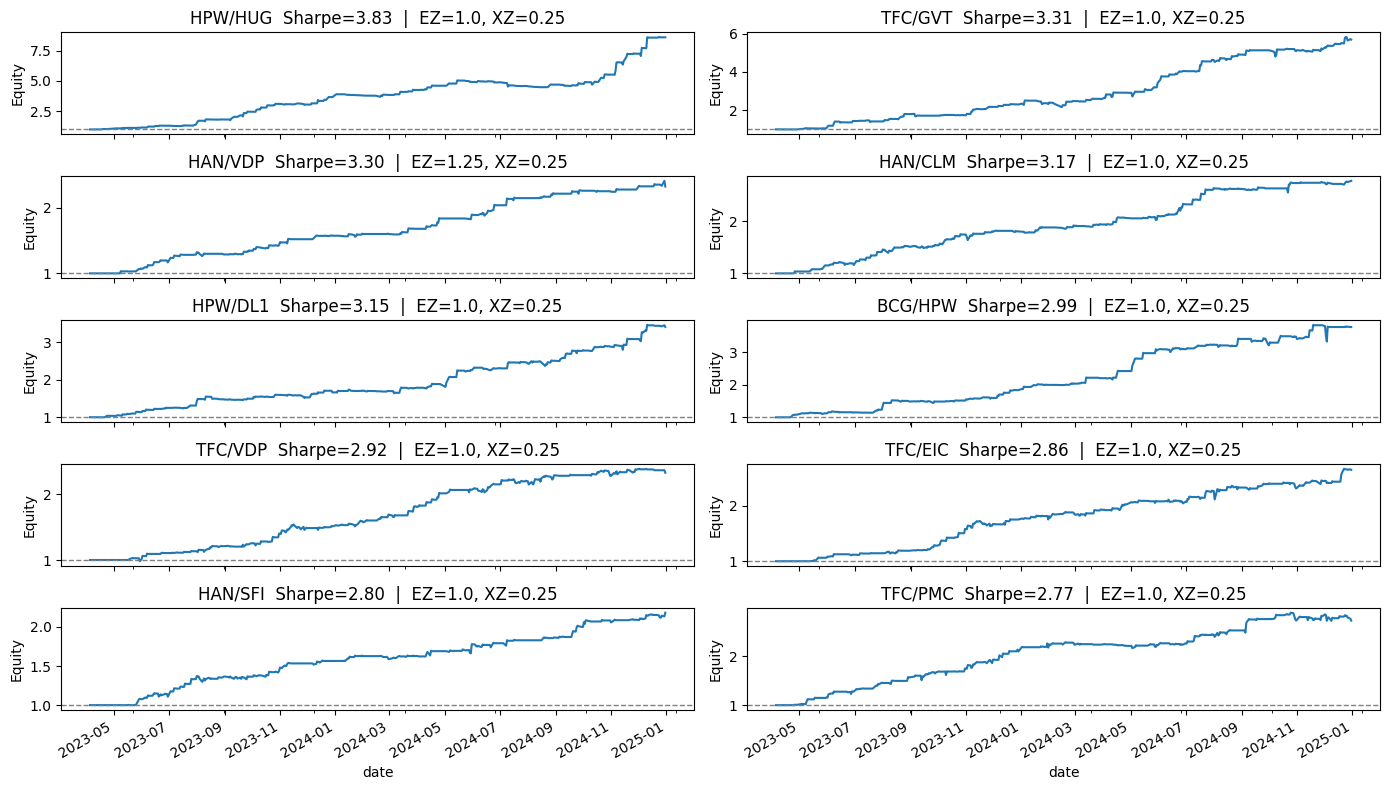

In [62]:
# 3) Build your DataFrame and pick top 10 by Sharpe
metrics_df = (
    pd.DataFrame(metrics)
      .set_index('pair')
      .loc[:, [
         'total_return','annual_return','volatility','sharpe','win_rate',
         'profit_factor','max_drawdown','cagr','num_trades','half_life',
         'entry_z','exit_z'
      ]]
)

top10 = metrics_df.sort_values('sharpe', ascending=False).head(10)
print("Top 10 pairs by Sharpe (using optimized thresholds):")
print(top10)

# ────────────────────────────────────────────────────────────────────────────────
# 4) Plot their equity curves
fig, axes = plt.subplots(5, 2, figsize=(14, 8), sharex=True)
axes = axes.flatten()
for ax, pair in zip(axes, top10.index):
    cumrets[pair].plot(ax=ax, lw=1.5)
    ax.axhline(1.0, linestyle='--', color='gray', linewidth=1)
    az, xz = top10.at[pair, 'entry_z'], top10.at[pair, 'exit_z']
    ax.set_title(f"{pair}  Sharpe={top10.at[pair,'sharpe']:.2f}  |  EZ={az}, XZ={xz}")
    ax.set_ylabel("Equity")
plt.tight_layout()
plt.show()

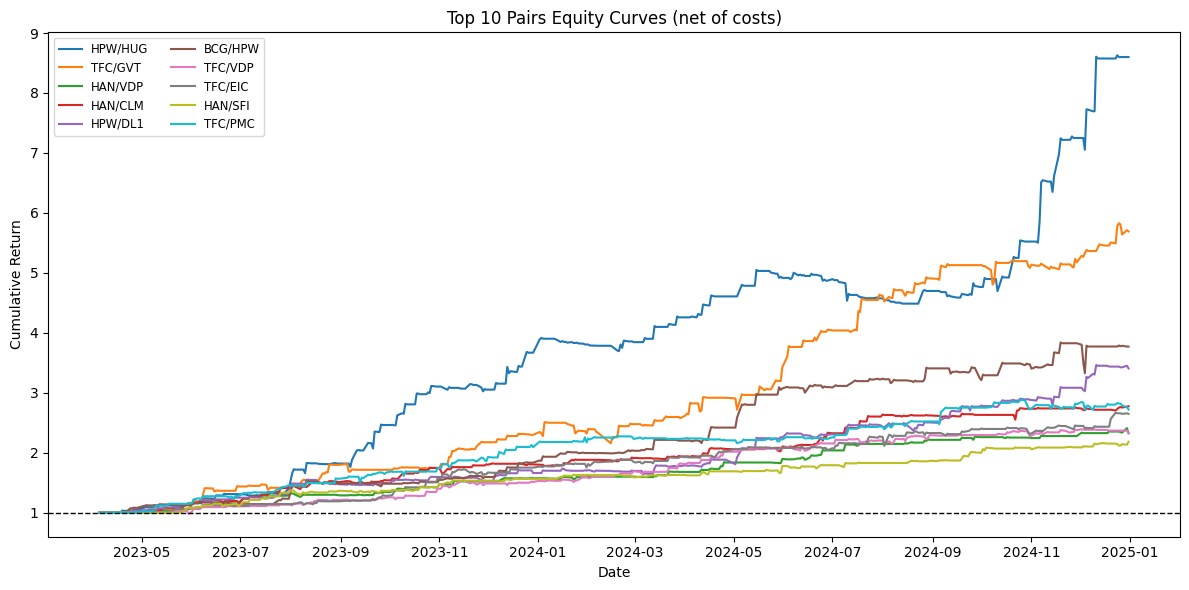

In [54]:
plt.figure(figsize=(12, 6))
for pair in top10.index:
    # cumrets[pair] is the pd.Series equity curve for that pair
    plt.plot(cumrets[pair], label=pair)

plt.axhline(1.0, color="k", linestyle="--", linewidth=1)
plt.legend(ncol=2, fontsize="small")
plt.title("Top 10 Pairs Equity Curves (net of costs)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.tight_layout()
plt.show()

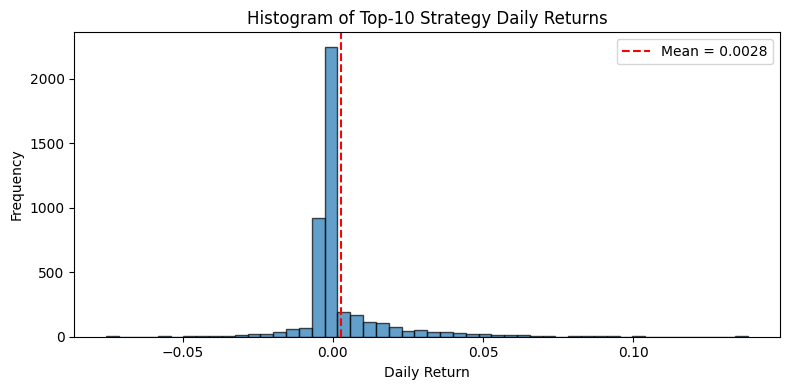

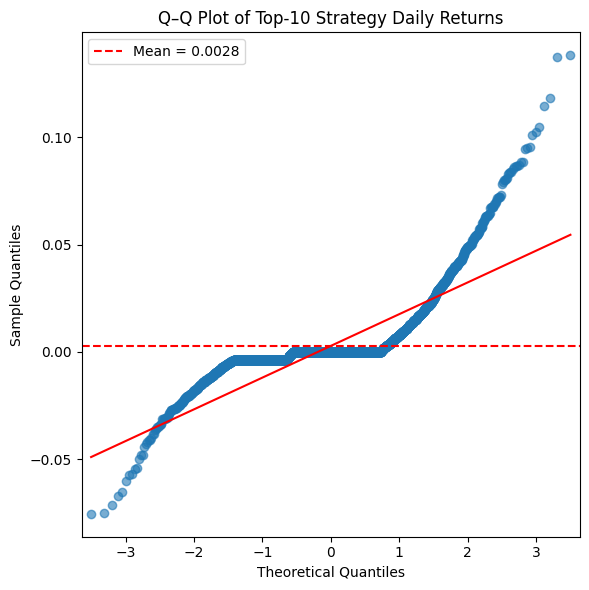

In [57]:
# 1) Collect all daily net returns from the top-10 equity series
all_rets = []
for pair in top10.index:
    eq = cumrets[pair]
    daily_ret = eq.pct_change().fillna(0)
    all_rets.append(daily_ret)
all_rets = pd.concat(all_rets)

# 2) Histogram of daily returns with mean line
mean_ret = all_rets.mean()

plt.figure(figsize=(8, 4))
plt.hist(all_rets, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(mean_ret, color='r', linestyle='--',
            label=f'Mean = {mean_ret:.4f}')
plt.title('Histogram of Top-10 Strategy Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# 3) Normal Q–Q plot with mean line
plt.figure(figsize=(6, 6))
sm.qqplot(all_rets, line='s', alpha=0.6, ax=plt.gca())
plt.title('Q–Q Plot of Top-10 Strategy Daily Returns')
plt.axhline(mean_ret, color='r', linestyle='--', label=f'Mean = {mean_ret:.4f}')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Phiên bản Vnstock 3.2.6 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.5

2025-07-03 21:35:32 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.
2025-07-03 21:35:34 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.



Benchmark VNINDEX:
  CAGR:         12.36%
  Sharpe Ratio: 0.62
  Ann. Vol:     14.87%
  Max Drawdown: 17.80%

Benchmark VN30:
  CAGR:         17.09%
  Sharpe Ratio: 0.77
  Ann. Vol:     15.69%
  Max Drawdown: 17.85%


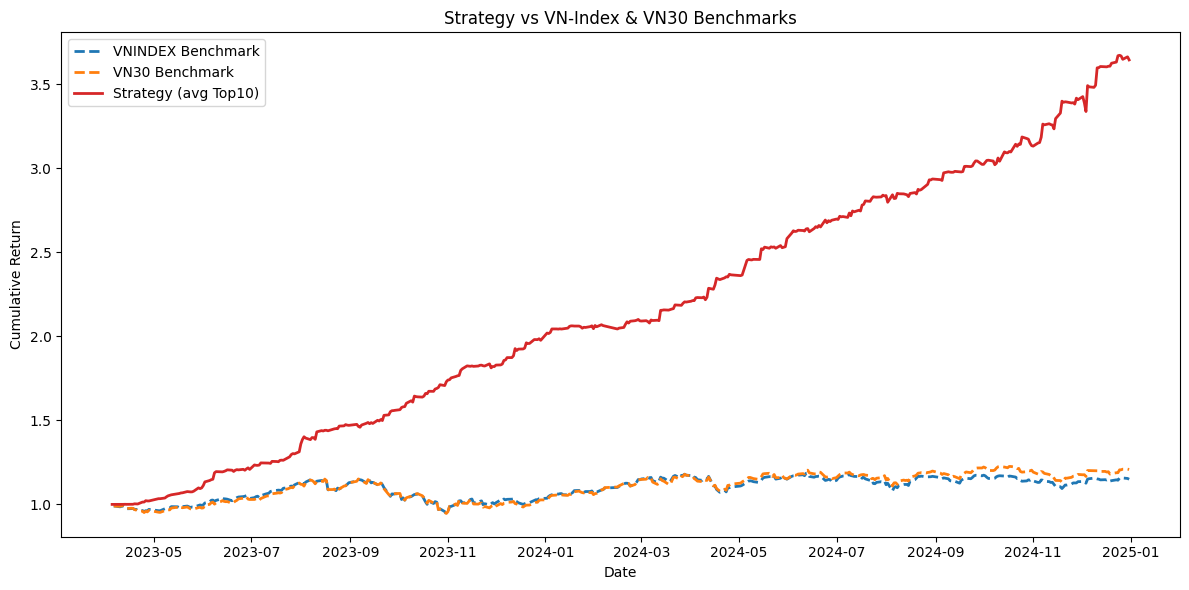

In [59]:
from vnstock import Vnstock

# 1) Derive test window from your strategy index (all cumrets share the same dates)
any_eq   = next(iter(cumrets.values()))
start_ts = any_eq.index[0]
end_ts   = any_eq.index[-1]

# 2) Fetch benchmarks
vn = Vnstock()
def fetch_index(symbol, start, end, source=None):
    idx = vn.stock(symbol=symbol, source=source)
    hist = idx.quote.history(
        start=start.strftime("%Y-%m-%d"),
        end=end.strftime("%Y-%m-%d"),
        interval="1D"
    )
    series = hist.set_index("time")["close"]
    series = series.reindex(any_eq.index).ffill()
    rets   = np.log(series).diff().dropna()
    cum    = (1 + rets).cumprod()
    ann_vol = rets.std() * sqrt(252)
    ann_ret = rets.mean() * 252
    sharpe  = ann_ret / ann_vol if ann_vol>0 else np.nan
    max_dd  = ((cum.cummax() - cum) / cum.cummax()).max()
    cagr    = cum.iloc[-1] ** (365.25/len(cum)) - 1
    return {
        "cum": cum,
        "vol": ann_vol,
        "ret": ann_ret,
        "sharpe": sharpe,
        "max_dd": max_dd,
        "cagr": cagr,
    }

benchmarks = {}
for sym in ["VNINDEX", "VN30"]:
    for src in ["VCI", "SSI", "TCBS"]:
        try:
            benchmarks[sym] = fetch_index(sym, start_ts, end_ts, source=src)
            break
        except:
            continue

# 3) Print benchmark stats
for sym, stats in benchmarks.items():
    print(f"\nBenchmark {sym}:")
    print(f"  CAGR:         {stats['cagr']:.2%}")
    print(f"  Sharpe Ratio: {stats['sharpe']:.2f}")
    print(f"  Ann. Vol:     {stats['vol']:.2%}")
    print(f"  Max Drawdown: {stats['max_dd']:.2%}")

# 4) Compute strategy average equity of the top-10
strat_avg = pd.concat([cumrets[p] for p in top10.index], axis=1).mean(axis=1)

# 5) Plot strategy vs benchmarks
plt.figure(figsize=(12, 6))
for sym, stats in benchmarks.items():
    plt.plot(stats["cum"], "--", lw=2, label=f"{sym} Benchmark")
plt.plot(strat_avg, "-", lw=2, color="tab:red", label="Strategy (avg Top10)")

plt.title("Strategy vs VN-Index & VN30 Benchmarks")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
# ─── 12) TOTAL RETURNS PERFORMANCE SUMMARY ──────────────────────────────────

# 1) Strategy metrics (on the average Top-10 equity curve)
strategy_eq       = strat_avg
rets_strat        = strategy_eq.pct_change().dropna()
strategy_total    = strategy_eq.iloc[-1] - 1
strategy_ann_ret  = rets_strat.mean() * 252
strategy_ann_vol  = rets_strat.std()  * np.sqrt(252)
strategy_sharpe   = strategy_ann_ret / strategy_ann_vol if strategy_ann_vol>0 else np.nan
strategy_dd       = (strategy_eq.cummax() - strategy_eq).max()
strategy_cagr     = strategy_eq.iloc[-1] ** (365.25 / len(strategy_eq)) - 1

print("\nTotal Returns Performance Summary")
print("──────────────────────────────────────────")
print(f"Strategy (Avg Top-10):")
print(f"  Total Return:      {strategy_total:.2%}")
print(f"  CAGR:              {strategy_cagr:.2%}")
print(f"  Ann. Volatility:   {strategy_ann_vol:.2%}")
print(f"  Sharpe Ratio:      {strategy_sharpe:.2f}")
print(f"  Max Drawdown:      {strategy_dd:.2%}\n")

# 2) Print each benchmark’s performance
for sym, stats in benchmarks.items():
    bench_eq    = stats["cum"]
    bench_total = bench_eq.iloc[-1] - 1
    print(f"Benchmark {sym}:")
    print(f"  Total Return:      {bench_total:.2%}")
    print(f"  CAGR:              {stats['cagr']:.2%}")
    print(f"  Ann. Volatility:   {stats['vol']:.2%}")
    print(f"  Sharpe Ratio:      {stats['sharpe']:.2f}")
    print(f"  Max Drawdown:      {stats['max_dd']:.2%}\n")


Total Returns Performance Summary
──────────────────────────────────────────
Strategy (Avg Top-10):
  Total Return:      264.47%
  CAGR:              194.02%
  Ann. Volatility:   11.63%
  Sharpe Ratio:      6.48
  Max Drawdown:      8.87%

Benchmark VNINDEX:
  Total Return:      14.96%
  CAGR:              12.36%
  Ann. Volatility:   14.87%
  Sharpe Ratio:      0.62
  Max Drawdown:      17.80%

Benchmark VN30:
  Total Return:      20.77%
  CAGR:              17.09%
  Ann. Volatility:   15.69%
  Sharpe Ratio:      0.77
  Max Drawdown:      17.85%



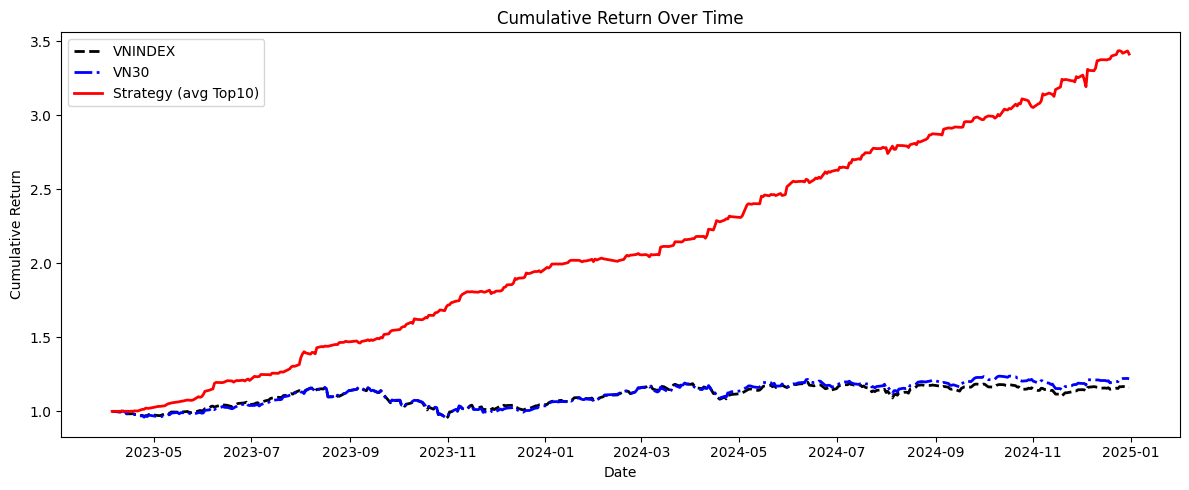

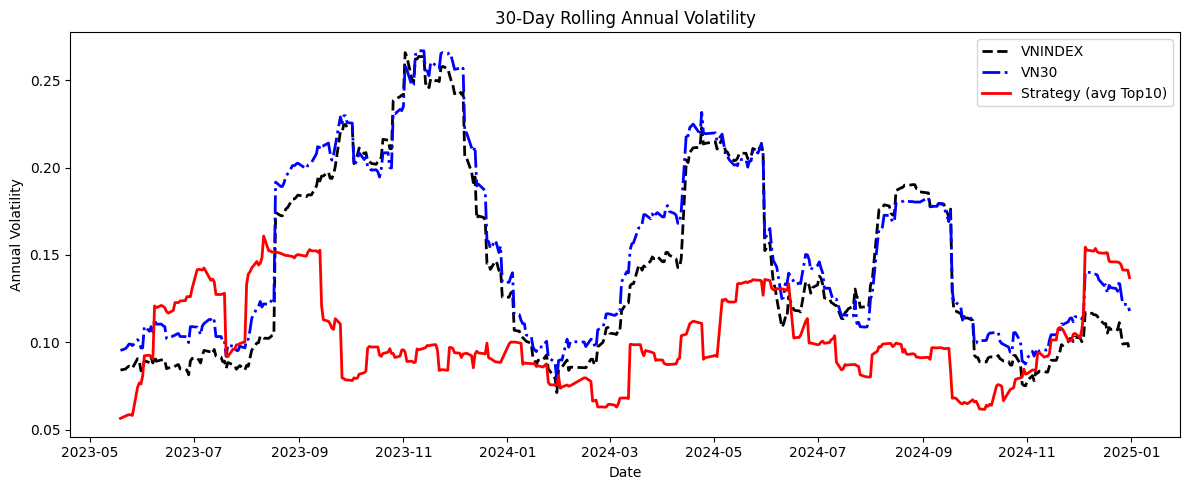

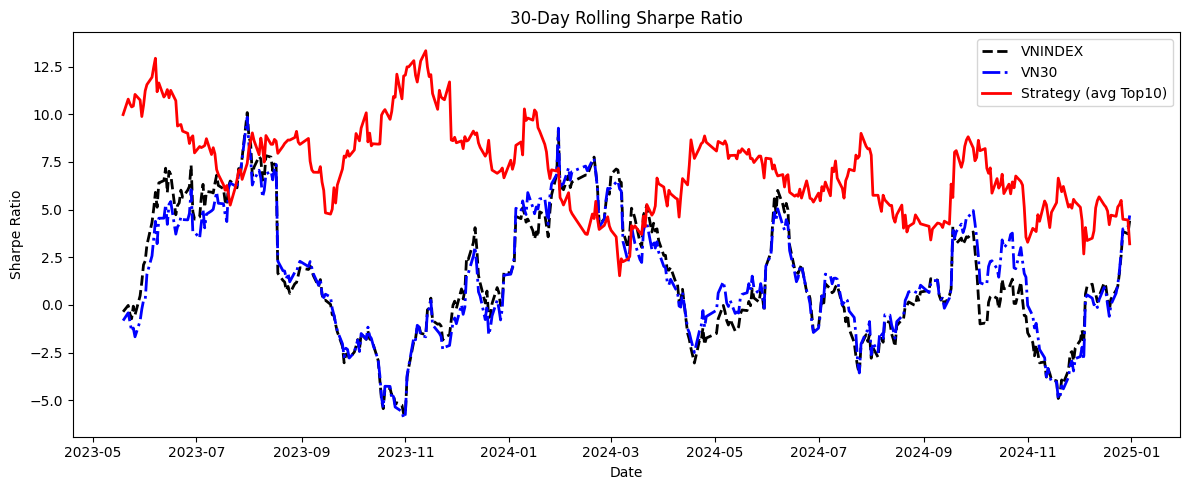

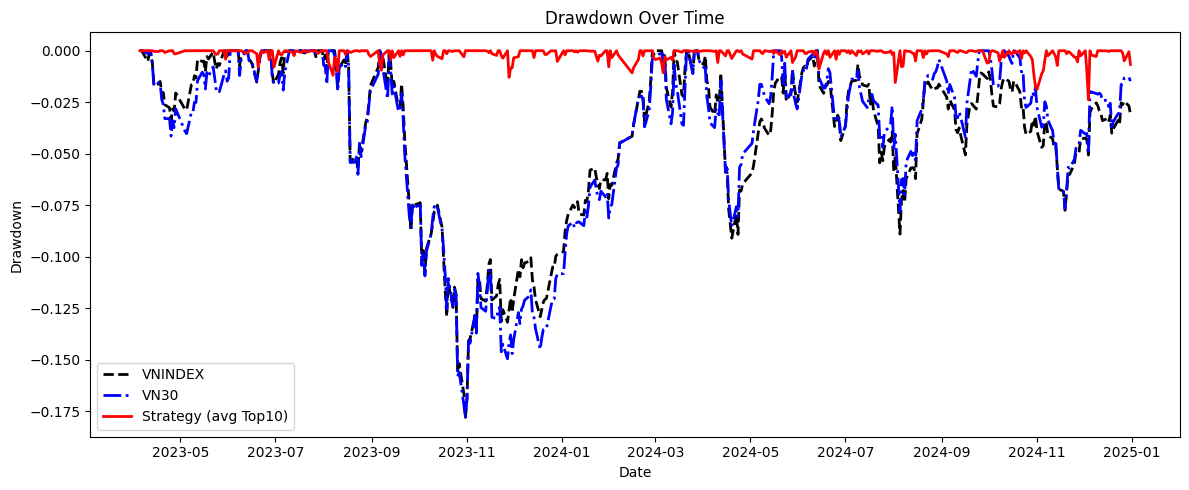

In [61]:
# ─── 10) ROLLING METRIC TIME-SERIES PLOTS FOR VN BENCHMARKS ────────────────────
WINDOW = 30  # rolling window in days

# 10.0) Strategy & benchmark daily returns
strat_ret = pd.concat(
    [cumrets[pair].pct_change().fillna(0) for pair in top10.index],
    axis=1
).mean(axis=1)

def get_index_rets(sym):
    series = benchmarks[sym]["cum"]
    rets   = series.pct_change().fillna(0)
    return rets.reindex(strat_ret.index).fillna(0)

vnidx_ret = get_index_rets("VNINDEX")
vn30_ret  = get_index_rets("VN30")

# 10.1) Cumulative returns
cum_strat = (1 + strat_ret).cumprod()
cum_vnidx = (1 + vnidx_ret).cumprod()
cum_vn30  = (1 + vn30_ret).cumprod()

# 10.2) Rolling annualized volatility
vol_strat = strat_ret.rolling(WINDOW).std() * np.sqrt(252)
vol_vnidx = vnidx_ret.rolling(WINDOW).std() * np.sqrt(252)
vol_vn30  = vn30_ret.rolling(WINDOW).std() * np.sqrt(252)

# 10.3) Rolling Sharpe ratio
sr_strat = (strat_ret.rolling(WINDOW).mean() /
            strat_ret.rolling(WINDOW).std()) * np.sqrt(252)
sr_vnidx = (vnidx_ret.rolling(WINDOW).mean()  /
            vnidx_ret.rolling(WINDOW).std())  * np.sqrt(252)
sr_vn30  = (vn30_ret.rolling(WINDOW).mean()   /
            vn30_ret.rolling(WINDOW).std())   * np.sqrt(252)

# 10.4) Drawdown series
dd_strat = cum_strat / cum_strat.cummax() - 1
dd_vnidx = cum_vnidx / cum_vnidx.cummax() - 1
dd_vn30  = cum_vn30  / cum_vn30.cummax()  - 1

# Plot helper
def ts_plot(s_strat, s_vnidx, s_vn30, title, ylabel):
    plt.figure(figsize=(12, 5))
    plt.plot(s_vnidx, "k--", lw=2, label="VNINDEX")
    plt.plot(s_vn30,  "b-.", lw=2, label="VN30")
    plt.plot(s_strat,"r-",  lw=2, label="Strategy (avg Top10)")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 10.1) Plot Cumulative Return
ts_plot(cum_strat, cum_vnidx, cum_vn30,
        "Cumulative Return Over Time", "Cumulative Return")

# 10.2) Plot Rolling 30-Day Annualized Volatility
ts_plot(vol_strat, vol_vnidx, vol_vn30,
        f"{WINDOW}-Day Rolling Annual Volatility", "Annual Volatility")

# 10.3) Plot Rolling 30-Day Sharpe Ratio
ts_plot(sr_strat, sr_vnidx, sr_vn30,
        f"{WINDOW}-Day Rolling Sharpe Ratio", "Sharpe Ratio")

# 10.4) Plot Drawdown Over Time
ts_plot(dd_strat, dd_vnidx, dd_vn30,
        "Drawdown Over Time", "Drawdown")